### Data loading is straight from Ramon's Exploration1 notebook

In [84]:
import numpy as np
import pandas as pd
import os
import tempfile

import matplotlib.pyplot as plt

%matplotlib inline

In [85]:
from os import listdir
from os.path import isfile, join
path_train = 'ignored_assets/public_data/training_data/order_data'
trainfiles = [f for f in listdir(path_train) if isfile(join(path_train, f)) and f != '.DS_Store']

path_test1 = 'ignored_assets/public_data/test_set_1/order_data'
testfiles1 = [f for f in listdir(path_test1) if isfile(join(path_test1, f)) and f != '.DS_Store']

path_test2 = 'ignored_assets/public_data/test_set_2/order_data'
testfiles2 = [f for f in listdir(path_test2) if isfile(join(path_test2, f)) and f != '.DS_Store']


In [86]:
orderdf_train = []
for f in trainfiles:
    orderdf_train.append(pd.read_csv(join(path_train, f), delimiter='\t', header = None))
    
orderdf_test = []
for f in testfiles1:
    orderdf_test.append(pd.read_csv(join(path_test1, f), delimiter='\t', header = None))
    
for f in testfiles2:
    orderdf_test.append(pd.read_csv(join(path_test2, f), delimiter='\t', header = None))


In [87]:
def group_and_label_data(orderdf):
    print "Concatenating and indexing"
    orderdf = pd.concat(orderdf)
    orderdf.index = range(len(orderdf))
    orderdf[6] = pd.to_datetime(orderdf[6])
    orderdf.columns = ['order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash', 'price', 'timestamp']
    orderdf['quarter_hour'] = orderdf['timestamp'].dt.round('15min')
    print "Grouping"
    orderdf_group=orderdf[['order_id', 'start_district_hash', 'quarter_hour']].groupby(['start_district_hash','quarter_hour']).count()
    orderdf_group.columns = ['Orders']
    orderdf_group=orderdf_group.reset_index()
    #orderdf_group=orderdf_group[orderdf_group['Orders']<200]
    print "Labeling"
    orderdf_group["quarter_hour_mins"] = orderdf_group['quarter_hour'].dt.minute+60*orderdf_group['quarter_hour'].dt.hour
    orderdf_group['hour'] = orderdf_group['quarter_hour'].dt.hour
    orderdf_group['weekday'] = orderdf_group['quarter_hour'].dt.weekday
    orderdf_group['weekend'] = orderdf_group['weekday']>4
    
    #Rescaling
    #orderdf_group["Orders"]=np.log(orderdf_group["Orders"])
    orderdf_group["Orders"]=orderdf_group["Orders"]>50
    
    return orderdf_group

In [88]:
orderdf_group_train=group_and_label_data(orderdf_train)
orderdf_group_test =group_and_label_data(orderdf_test)

Concatenating and indexing
Grouping
Labeling
Concatenating and indexing
Grouping
Labeling


In [89]:
orderdf_group_train.head()

,start_district_hash,quarter_hour,Orders,quarter_hour_mins,hour,weekday,weekend
0,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01 00:45:00,0.693147,45,0,4,False
1,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01 01:00:00,0.693147,60,1,4,False
2,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01 01:15:00,0.693147,75,1,4,False
3,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01 02:15:00,0.000000,135,2,4,False
4,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01 02:30:00,0.693147,150,2,4,False


### Let's create a stupid linear classifier with TensorFlow

In [90]:
CATEGORICAL_COLUMNS = ["start_district_hash", "quarter_hour_mins","hour", "weekday", "weekend"]
CONTINUOUS_COLUMNS = []
LABEL_COLUMN = ["Orders"]

In [91]:
import tensorflow as tf

def input_fn(df):
  # Creates a dictionary mapping from each continuous feature column name (k) to
  # the values of that column stored in a constant Tensor.
  continuous_cols = {k: tf.constant(df[k].values)
                     for k in CONTINUOUS_COLUMNS}
  # Creates a dictionary mapping from each categorical feature column name (k)
  # to the values of that column stored in a tf.SparseTensor.
  categorical_cols = {k: tf.SparseTensor(
      indices=[[i, 0] for i in range(df[k].size)],
      values=df[k].values,
      dense_shape=[df[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
  # Merges the two dictionaries into one.
  feature_cols = dict(continuous_cols.items() + categorical_cols.items())
  # Converts the label column into a constant Tensor.
  label = tf.constant(df[LABEL_COLUMN].values)
  # Returns the feature columns and the label.
  return feature_cols, label

def train_input_fn():
  return input_fn(orderdf_group_train)

def eval_input_fn():
  return input_fn(orderdf_group_test)


In [100]:
#start_district_hash = tf.contrib.layers.sparse_column_with_keys(
#  column_name="start_district_hash", keys=["Female", "Male"])
start_district_hash = tf.contrib.layers.sparse_column_with_hash_bucket("start_district_hash", hash_bucket_size=66)
quarter_hour_mins = tf.contrib.layers.sparse_column_with_integerized_feature("quarter_hour_mins",bucket_size=144)
hour = tf.contrib.layers.sparse_column_with_integerized_feature("hour",bucket_size=24)
weekday = tf.contrib.layers.sparse_column_with_integerized_feature("weekday",bucket_size=7)
#weekend = tf.contrib.layers.bucketized_column("weekend", hash_bucket_size=2)
weekend = tf.contrib.layers.sparse_column_with_integerized_feature("weekend",bucket_size=2)

#TODO use sparse_column_with_integerized_feature 

In [101]:
model_dir = tempfile.mkdtemp()
#m = tf.contrib.learn.LinearRegressor(feature_columns=[
m = tf.contrib.learn.LinearRegressor(feature_columns=[
  start_district_hash, quarter_hour_mins, hour, weekday],
    #optimizer=tf.train.FtrlOptimizer(
    #learning_rate=0.1,
    #l1_regularization_strength=1.0,
    #l2_regularization_strength=1.0),
  model_dir=model_dir)


INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': None, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x17b680ad0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


INFO:tensorflow:Using config: {'_model_dir': None, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x17b680ad0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


In [102]:
m.fit(input_fn=train_input_fn, steps=5000)

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into /var/folders/78/dgqg3y1961n3hr5x51lmkmbc0000gp/T/tmptT20Yd/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1 into /var/folders/78/dgqg3y1961n3hr5x51lmkmbc0000gp/T/tmptT20Yd/model.ckpt.


INFO:tensorflow:loss = 11.3931, step = 1


INFO:tensorflow:loss = 11.3931, step = 1


INFO:tensorflow:global_step/sec: 81.1158


INFO:tensorflow:global_step/sec: 81.1158


INFO:tensorflow:loss = 1.19426, step = 101 (1.234 sec)


INFO:tensorflow:loss = 1.19426, step = 101 (1.234 sec)


INFO:tensorflow:global_step/sec: 101.975


INFO:tensorflow:global_step/sec: 101.975


INFO:tensorflow:loss = 1.10517, step = 201 (0.981 sec)


INFO:tensorflow:loss = 1.10517, step = 201 (0.981 sec)


INFO:tensorflow:global_step/sec: 111.606


INFO:tensorflow:global_step/sec: 111.606


INFO:tensorflow:loss = 1.09575, step = 301 (0.896 sec)


INFO:tensorflow:loss = 1.09575, step = 301 (0.896 sec)


INFO:tensorflow:global_step/sec: 110.336


INFO:tensorflow:global_step/sec: 110.336


INFO:tensorflow:loss = 1.09427, step = 401 (0.906 sec)


INFO:tensorflow:loss = 1.09427, step = 401 (0.906 sec)


INFO:tensorflow:global_step/sec: 112.275


INFO:tensorflow:global_step/sec: 112.275


INFO:tensorflow:loss = 1.09394, step = 501 (0.891 sec)


INFO:tensorflow:loss = 1.09394, step = 501 (0.891 sec)


INFO:tensorflow:global_step/sec: 111.629


INFO:tensorflow:global_step/sec: 111.629


INFO:tensorflow:loss = 1.09385, step = 601 (0.896 sec)


INFO:tensorflow:loss = 1.09385, step = 601 (0.896 sec)


INFO:tensorflow:global_step/sec: 112.028


INFO:tensorflow:global_step/sec: 112.028


INFO:tensorflow:loss = 1.09383, step = 701 (0.893 sec)


INFO:tensorflow:loss = 1.09383, step = 701 (0.893 sec)


INFO:tensorflow:global_step/sec: 109.435


INFO:tensorflow:global_step/sec: 109.435


INFO:tensorflow:loss = 1.09382, step = 801 (0.914 sec)


INFO:tensorflow:loss = 1.09382, step = 801 (0.914 sec)


INFO:tensorflow:global_step/sec: 104.286


INFO:tensorflow:global_step/sec: 104.286


INFO:tensorflow:loss = 1.09382, step = 901 (0.959 sec)


INFO:tensorflow:loss = 1.09382, step = 901 (0.959 sec)


INFO:tensorflow:global_step/sec: 109.895


INFO:tensorflow:global_step/sec: 109.895


INFO:tensorflow:loss = 1.09381, step = 1001 (0.910 sec)


INFO:tensorflow:loss = 1.09381, step = 1001 (0.910 sec)


INFO:tensorflow:global_step/sec: 98.3783


INFO:tensorflow:global_step/sec: 98.3783


INFO:tensorflow:loss = 1.09381, step = 1101 (1.016 sec)


INFO:tensorflow:loss = 1.09381, step = 1101 (1.016 sec)


INFO:tensorflow:global_step/sec: 109.677


INFO:tensorflow:global_step/sec: 109.677


INFO:tensorflow:loss = 1.09381, step = 1201 (0.912 sec)


INFO:tensorflow:loss = 1.09381, step = 1201 (0.912 sec)


INFO:tensorflow:global_step/sec: 101.452


INFO:tensorflow:global_step/sec: 101.452


INFO:tensorflow:loss = 1.09381, step = 1301 (0.986 sec)


INFO:tensorflow:loss = 1.09381, step = 1301 (0.986 sec)


INFO:tensorflow:global_step/sec: 88.2976


INFO:tensorflow:global_step/sec: 88.2976


INFO:tensorflow:loss = 1.09381, step = 1401 (1.133 sec)


INFO:tensorflow:loss = 1.09381, step = 1401 (1.133 sec)


INFO:tensorflow:global_step/sec: 94.3624


INFO:tensorflow:global_step/sec: 94.3624


INFO:tensorflow:loss = 1.09381, step = 1501 (1.060 sec)


INFO:tensorflow:loss = 1.09381, step = 1501 (1.060 sec)


INFO:tensorflow:global_step/sec: 85.2764


INFO:tensorflow:global_step/sec: 85.2764


INFO:tensorflow:loss = 1.09381, step = 1601 (1.173 sec)


INFO:tensorflow:loss = 1.09381, step = 1601 (1.173 sec)


INFO:tensorflow:global_step/sec: 102.383


INFO:tensorflow:global_step/sec: 102.383


INFO:tensorflow:loss = 1.09381, step = 1701 (0.977 sec)


INFO:tensorflow:loss = 1.09381, step = 1701 (0.977 sec)


INFO:tensorflow:global_step/sec: 106.919


INFO:tensorflow:global_step/sec: 106.919


INFO:tensorflow:loss = 1.09381, step = 1801 (0.935 sec)


INFO:tensorflow:loss = 1.09381, step = 1801 (0.935 sec)


INFO:tensorflow:global_step/sec: 106.514


INFO:tensorflow:global_step/sec: 106.514


INFO:tensorflow:loss = 1.09381, step = 1901 (0.939 sec)


INFO:tensorflow:loss = 1.09381, step = 1901 (0.939 sec)


INFO:tensorflow:global_step/sec: 100.733


INFO:tensorflow:global_step/sec: 100.733


INFO:tensorflow:loss = 1.09381, step = 2001 (0.993 sec)


INFO:tensorflow:loss = 1.09381, step = 2001 (0.993 sec)


INFO:tensorflow:global_step/sec: 83.736


INFO:tensorflow:global_step/sec: 83.736


INFO:tensorflow:loss = 1.09381, step = 2101 (1.194 sec)


INFO:tensorflow:loss = 1.09381, step = 2101 (1.194 sec)


INFO:tensorflow:global_step/sec: 105.35


INFO:tensorflow:global_step/sec: 105.35


INFO:tensorflow:loss = 1.09381, step = 2201 (0.949 sec)


INFO:tensorflow:loss = 1.09381, step = 2201 (0.949 sec)


INFO:tensorflow:global_step/sec: 107.505


INFO:tensorflow:global_step/sec: 107.505


INFO:tensorflow:loss = 1.09381, step = 2301 (0.930 sec)


INFO:tensorflow:loss = 1.09381, step = 2301 (0.930 sec)


INFO:tensorflow:global_step/sec: 109.858


INFO:tensorflow:global_step/sec: 109.858


INFO:tensorflow:loss = 1.09381, step = 2401 (0.910 sec)


INFO:tensorflow:loss = 1.09381, step = 2401 (0.910 sec)


INFO:tensorflow:global_step/sec: 109.965


INFO:tensorflow:global_step/sec: 109.965


INFO:tensorflow:loss = 1.09381, step = 2501 (0.909 sec)


INFO:tensorflow:loss = 1.09381, step = 2501 (0.909 sec)


INFO:tensorflow:global_step/sec: 106.203


INFO:tensorflow:global_step/sec: 106.203


INFO:tensorflow:loss = 1.09381, step = 2601 (0.942 sec)


INFO:tensorflow:loss = 1.09381, step = 2601 (0.942 sec)


INFO:tensorflow:global_step/sec: 107.133


INFO:tensorflow:global_step/sec: 107.133


INFO:tensorflow:loss = 1.09381, step = 2701 (0.933 sec)


INFO:tensorflow:loss = 1.09381, step = 2701 (0.933 sec)


INFO:tensorflow:global_step/sec: 105.803


INFO:tensorflow:global_step/sec: 105.803


INFO:tensorflow:loss = 1.09381, step = 2801 (0.945 sec)


INFO:tensorflow:loss = 1.09381, step = 2801 (0.945 sec)


INFO:tensorflow:global_step/sec: 107.359


INFO:tensorflow:global_step/sec: 107.359


INFO:tensorflow:loss = 1.09381, step = 2901 (0.932 sec)


INFO:tensorflow:loss = 1.09381, step = 2901 (0.932 sec)


INFO:tensorflow:global_step/sec: 108.452


INFO:tensorflow:global_step/sec: 108.452


INFO:tensorflow:loss = 1.09381, step = 3001 (0.922 sec)


INFO:tensorflow:loss = 1.09381, step = 3001 (0.922 sec)


INFO:tensorflow:global_step/sec: 109.956


INFO:tensorflow:global_step/sec: 109.956


INFO:tensorflow:loss = 1.09381, step = 3101 (0.909 sec)


INFO:tensorflow:loss = 1.09381, step = 3101 (0.909 sec)


INFO:tensorflow:global_step/sec: 110.388


INFO:tensorflow:global_step/sec: 110.388


INFO:tensorflow:loss = 1.09381, step = 3201 (0.906 sec)


INFO:tensorflow:loss = 1.09381, step = 3201 (0.906 sec)


INFO:tensorflow:global_step/sec: 101.009


INFO:tensorflow:global_step/sec: 101.009


INFO:tensorflow:loss = 1.09381, step = 3301 (0.990 sec)


INFO:tensorflow:loss = 1.09381, step = 3301 (0.990 sec)


INFO:tensorflow:global_step/sec: 102.334


INFO:tensorflow:global_step/sec: 102.334


INFO:tensorflow:loss = 1.09381, step = 3401 (0.977 sec)


INFO:tensorflow:loss = 1.09381, step = 3401 (0.977 sec)


INFO:tensorflow:global_step/sec: 102.212


INFO:tensorflow:global_step/sec: 102.212


INFO:tensorflow:loss = 1.09381, step = 3501 (0.978 sec)


INFO:tensorflow:loss = 1.09381, step = 3501 (0.978 sec)


INFO:tensorflow:global_step/sec: 106.463


INFO:tensorflow:global_step/sec: 106.463


INFO:tensorflow:loss = 1.09381, step = 3601 (0.939 sec)


INFO:tensorflow:loss = 1.09381, step = 3601 (0.939 sec)


INFO:tensorflow:global_step/sec: 111.224


INFO:tensorflow:global_step/sec: 111.224


INFO:tensorflow:loss = 1.09381, step = 3701 (0.899 sec)


INFO:tensorflow:loss = 1.09381, step = 3701 (0.899 sec)


INFO:tensorflow:global_step/sec: 107.341


INFO:tensorflow:global_step/sec: 107.341


INFO:tensorflow:loss = 1.09381, step = 3801 (0.932 sec)


INFO:tensorflow:loss = 1.09381, step = 3801 (0.932 sec)


INFO:tensorflow:global_step/sec: 111.651


INFO:tensorflow:global_step/sec: 111.651


INFO:tensorflow:loss = 1.09381, step = 3901 (0.896 sec)


INFO:tensorflow:loss = 1.09381, step = 3901 (0.896 sec)


INFO:tensorflow:global_step/sec: 110.32


INFO:tensorflow:global_step/sec: 110.32


INFO:tensorflow:loss = 1.09381, step = 4001 (0.906 sec)


INFO:tensorflow:loss = 1.09381, step = 4001 (0.906 sec)


INFO:tensorflow:global_step/sec: 105.498


INFO:tensorflow:global_step/sec: 105.498


INFO:tensorflow:loss = 1.09381, step = 4101 (0.948 sec)


INFO:tensorflow:loss = 1.09381, step = 4101 (0.948 sec)


INFO:tensorflow:global_step/sec: 110.377


INFO:tensorflow:global_step/sec: 110.377


INFO:tensorflow:loss = 1.09381, step = 4201 (0.906 sec)


INFO:tensorflow:loss = 1.09381, step = 4201 (0.906 sec)


INFO:tensorflow:global_step/sec: 98.8308


INFO:tensorflow:global_step/sec: 98.8308


INFO:tensorflow:loss = 1.09381, step = 4301 (1.012 sec)


INFO:tensorflow:loss = 1.09381, step = 4301 (1.012 sec)


INFO:tensorflow:global_step/sec: 99.474


INFO:tensorflow:global_step/sec: 99.474


INFO:tensorflow:loss = 1.09381, step = 4401 (1.005 sec)


INFO:tensorflow:loss = 1.09381, step = 4401 (1.005 sec)


INFO:tensorflow:global_step/sec: 95.7613


INFO:tensorflow:global_step/sec: 95.7613


INFO:tensorflow:loss = 1.09381, step = 4501 (1.044 sec)


INFO:tensorflow:loss = 1.09381, step = 4501 (1.044 sec)


INFO:tensorflow:global_step/sec: 98.2305


INFO:tensorflow:global_step/sec: 98.2305


INFO:tensorflow:loss = 1.09381, step = 4601 (1.018 sec)


INFO:tensorflow:loss = 1.09381, step = 4601 (1.018 sec)


INFO:tensorflow:global_step/sec: 108.433


INFO:tensorflow:global_step/sec: 108.433


INFO:tensorflow:loss = 1.09381, step = 4701 (0.922 sec)


INFO:tensorflow:loss = 1.09381, step = 4701 (0.922 sec)


INFO:tensorflow:global_step/sec: 110.995


INFO:tensorflow:global_step/sec: 110.995


INFO:tensorflow:loss = 1.09381, step = 4801 (0.901 sec)


INFO:tensorflow:loss = 1.09381, step = 4801 (0.901 sec)


INFO:tensorflow:global_step/sec: 104.531


INFO:tensorflow:global_step/sec: 104.531


INFO:tensorflow:loss = 1.09381, step = 4901 (0.957 sec)


INFO:tensorflow:loss = 1.09381, step = 4901 (0.957 sec)


INFO:tensorflow:Saving checkpoints for 5000 into /var/folders/78/dgqg3y1961n3hr5x51lmkmbc0000gp/T/tmptT20Yd/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5000 into /var/folders/78/dgqg3y1961n3hr5x51lmkmbc0000gp/T/tmptT20Yd/model.ckpt.


INFO:tensorflow:Loss for final step: 1.09381.


INFO:tensorflow:Loss for final step: 1.09381.


LinearRegressor(params={'gradient_clip_norm': None, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x17b680c50>, 'joint_weights': False, 'optimizer': None, 'feature_columns': [_SparseColumn(column_name='start_district_hash', is_integerized=False, bucket_size=66, lookup_config=None, combiner='sum', dtype=tf.string), _SparseColumn(column_name='quarter_hour_mins', is_integerized=True, bucket_size=144, lookup_config=None, combiner='sum', dtype=tf.int64), _SparseColumn(column_name='hour', is_integerized=True, bucket_size=24, lookup_config=None, combiner='sum', dtype=tf.int64), _SparseColumn(column_name='weekday', is_integerized=True, bucket_size=7, lookup_config=None, combiner='sum', dtype=tf.int64)]})

In [103]:
results = m.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(results):
    print("%s: %s" % (key, results[key]))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Starting evaluation at 2017-05-12-22:06:21


INFO:tensorflow:Starting evaluation at 2017-05-12-22:06:21


INFO:tensorflow:Restoring parameters from /var/folders/78/dgqg3y1961n3hr5x51lmkmbc0000gp/T/tmptT20Yd/model.ckpt-5000


INFO:tensorflow:Restoring parameters from /var/folders/78/dgqg3y1961n3hr5x51lmkmbc0000gp/T/tmptT20Yd/model.ckpt-5000


INFO:tensorflow:Evaluation [1/1]


INFO:tensorflow:Evaluation [1/1]


INFO:tensorflow:Finished evaluation at 2017-05-12-22:06:22


INFO:tensorflow:Finished evaluation at 2017-05-12-22:06:22


INFO:tensorflow:Saving dict for global step 5000: global_step = 5000, loss = 1.26211


INFO:tensorflow:Saving dict for global step 5000: global_step = 5000, loss = 1.26211


global_step: 5000
loss: 1.26211


In [104]:
int(eval_input_fn()[1].shape[0])

15715

In [105]:
preds = list(m.predict(input_fn=eval_input_fn))

Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.


Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.


INFO:tensorflow:Restoring parameters from /var/folders/78/dgqg3y1961n3hr5x51lmkmbc0000gp/T/tmptT20Yd/model.ckpt-5000


INFO:tensorflow:Restoring parameters from /var/folders/78/dgqg3y1961n3hr5x51lmkmbc0000gp/T/tmptT20Yd/model.ckpt-5000


[0, 1000, 0, 1000]

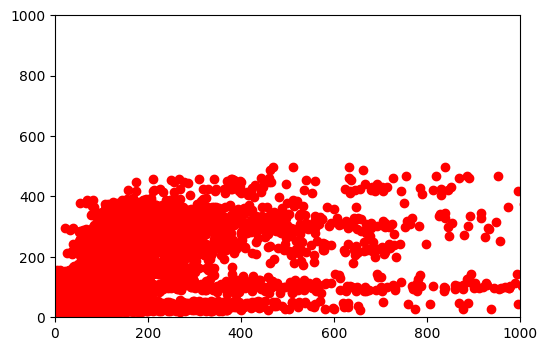

In [107]:
plt.plot(np.exp(orderdf_group_test['Orders']),np.exp(preds),'ro')
plt.axis([0, 1000, 0, 1000])

In [99]:
max(orderdf_group_test['Orders'])

7.779048644925556

(array([ 8714.,  1886.,   935.,   760.,   491.,   370.,   335.,   287.,
          244.,   181.]),
 array([   1. ,   20.8,   40.6,   60.4,   80.2,  100. ,  119.8,  139.6,
         159.4,  179.2,  199. ]),
 <a list of 10 Patch objects>)

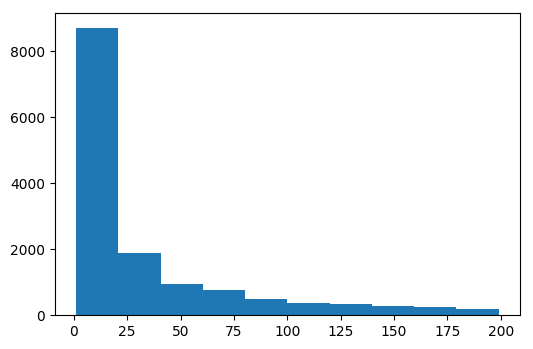

In [45]:
plt.hist(orderdf_group_test['Orders'][orderdf_group_test['Orders']<200])